<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 50px"> 

#   Personalizing Music Video Recommendations with Emotional Intelligence

> Capstone Project: Lionel Foo

---

#### <b> Notebook: 02B Classification Model (Multiclass Classification - DistilBERT) </b>

<b>(a) Context: Rationale for Incorporating BERT and DistilBERT</b>

BERT and DistilBERT are transformer-based models that have revolutionized the field of Natural Language Processing (NLP). They capture the context of words in a sentence and represent them as high-dimensional vectors. These models are pre-trained on a large corpus of text and can be fine-tuned for specific tasks.

Unlike traditional machine learning models, BERT and DistilBERT understand the semantic meaning of words based on their context. They retain stop words such as "to", "but", "not", which are often filtered out in traditional NLP pipelines. These stop words can provide essential context information.

Moreover, BERT and DistilBERT do not require lemmatization, a process that reduces words to their base or root form. They can understand that different forms of the same word can carry different meanings. For example, "computer" and "computerized" have different connotations and should be represented differently.

DistilBERT is a smaller, faster, and more resource-efficient version of BERT. It retains most of BERT's performance while being significantly smaller and faster, making it suitable for environments with limited computational resources.

<font size="1.5">

References: 

[1] Hugging Face. DistilBERT. <br>https://huggingface.co/docs/transformers/model_doc/distilbert

[2] Victor Sanh, Lysandre Debut, Julien Chaumond, Thomas Wolf. DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. <br>https://arxiv.org/abs/1910.01108

[3] Stack Overflow. Is it necessary to do stopwords removal, Stemming/Lemmatization for text classification while using Spacy, Bert? <br>https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif

</font>

<br>
<b>(b) Incorporating BERT and DistilBERT - Text-Preprocessing: Retention of Stop Words and No Lemmatisation</b>

A review of words within the BERT and DistilBERT vocabulary reveals the presence of: 
* Stop words (e.g., "to", "but", "not")
* Words with similar lemmas that have different word vectors (e.g., "computer", "computerized", "supercomputers")

As such, stop words will be retained, and lemmatisation will not be performed. This is because BERT and DistilBERT are capable of understanding the context in which a word is used, and different forms of the same word can carry different meanings. For example, "computer" and "computerized" have different connotations and should be represented differently.

---

<b> 1. Import Libraries</b>

In [25]:
# Imports
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
from tensorflow.keras import models, layers, metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


---

<b> 2. Import dataframe and assess imported data </b>

In [2]:
# Import data
df = pd.read_csv("Data/emotions_processed_dataset.csv")

In [3]:
# Check top 10 rows of imported data
df.head(10)

,text,label,emotion_name
0,i just feel really helpless and heavy hearted,4,Fear
1,i have enjoyed being able to slouch about rela...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,Fear
3,i do not know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,Fear
5,i was beginning to feel quite disheartened,0,Sadness
6,i would think that whomever would be lucky eno...,2,Love
7,i fear that they will not ever feel that delic...,1,Joy
8,i can still lose the weight without feeling de...,0,Sadness
9,i try to be nice though so if you get a bitchy...,1,Joy


In [4]:
# Summary of DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380365 entries, 0 to 380364
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text          380365 non-null  object
 1   label         380365 non-null  int64 
 2   emotion_name  380365 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.7+ MB


In [5]:
# Check for null values in the 'text' column
df['text'].isnull().sum()

0

In [6]:
# check for class imbalance
df['label'].value_counts()

label
1    134709
0    118152
3     54597
4     43497
2     29410
Name: count, dtype: int64

---

<b> 2. Prepare Data for Modelling </b>

Outline
* (a) Define X and y
* (b) Tokenize X using DistilBertTokenizer
* (c) Perform Train-Test-Split
* (d) Evaluate Class Imbalance
* (e) Address Class Imbalance
* (f) Tokenise & Pad Text Sequences

<b> (a) Define X and y </b>

In [7]:
# define X and y
X = df['text']
y = df['label'].to_numpy()
y

array([4, 0, 4, ..., 1, 2, 3])

<b> (b) Tokenize X using DistilBertTokenizer </b>

In [8]:
# Define the tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [9]:
# Tokenize X
X_tf = [tokenizer(text, padding='max_length', max_length = 54, truncation=True)['input_ids'] for text in X]
X_tf = np.array(X_tf, dtype='int32')

<b> (c) Perform Train-Test-Split </b>

In [10]:
# Train/test split
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of training data: ',X_tf_train.shape)
print('Shape of test data: ',X_tf_test.shape)

Shape of training data:  (304292, 54)
Shape of test data:  (76073, 54)


<b> (d) Evaluate Class Imbalance </b>

In [11]:
# check class imbalance for training dataset
unique, counts = np.unique(y_tf_train, return_counts=True)

# print the unique values and their counts
for u, c in zip(unique, counts):
    print(f"Value: {u}, Count: {c}")

Value: 0, Count: 94522
Value: 1, Count: 107767
Value: 2, Count: 23528
Value: 3, Count: 43678
Value: 4, Count: 34797


Comments: Class Imbalance
* Class [0]: Sadness ; Class [1]: Joy, Class [2]: Love, Class [3]: Anger, Class [4]: Fear
* There are a disproportionately high number of "Sadness" (94522), "Joy" (107767), and "Anger" (43678) instances.
* There are a disproportionately low number of "Love" (23528) instances.

Comments: Approach to Addressing Class Imbalance
* Undersampling (oversampling) of the most (least) numerous class to attain a count equivalent to the "Fear" class (as it has a count between both classes), where we'll:
    * undersample: the most numerous classes ("Sadness", "Joy", and "Anger") 
    * oversample: the least numerous class ("Love")

* To prevent "training" data from leaking into the "testing" data - the class rebalancing procedure will be applied:
    * after the "train-test-split" step, and
    * applied to the "training" sample only

<b> (e) Address Class Imbalance </b>

In [12]:
# Balance classes of training data to sample count of class 4

df_train = pd.DataFrame(X_tf_train)
df_train['label'] = y_tf_train

# Downsampling
class_0 = df_train[df_train["label"] == 0].sample(n=34797, random_state=42)
class_1 = df_train[df_train["label"] == 1].sample(n=34797, random_state=42)
class_3 = df_train[df_train["label"] == 3].sample(n=34797, random_state=42)

# Upsampling
class_2 = df_train[df_train["label"] == 2]
upsampled_class_2 = class_2.sample(n=34797, replace=True, random_state=42)

# Keeping class 4 as it is
class_4 = df_train[df_train["label"] == 4]

df_train_balanced = pd.concat([class_0, class_1, upsampled_class_2, class_3, class_4], axis=0)

X_tf_train_balanced = df_train_balanced.drop(columns=['label']).values
y_tf_train_balanced = df_train_balanced['label'].values


In [13]:
# recheck class distribution after rebalancing
unique, counts = np.unique(y_tf_train_balanced, return_counts=True)

# print the unique values and their counts
for u, c in zip(unique, counts):
    print(f"Value: {u}, Count: {c}")

Value: 0, Count: 34797
Value: 1, Count: 34797
Value: 2, Count: 34797
Value: 3, Count: 34797
Value: 4, Count: 34797


In [14]:
print('Shape of balanced training data: ',X_tf_train_balanced.shape)

Shape of balanced training data:  (173985, 54)


---

<b> 3. Train Classification Model using Distilbert </b>

In [15]:
# Get BERT layer
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
# create a sample of size 5 from the training data to test out bert layer
sample = X_tf_train_balanced[0:5]
print('Object type: ', type(dbert_tf(sample)))
print('Output format (shape): ',dbert_tf(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_tf(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
Output format (shape):  (5, 54, 768)
Output used as input for the classifier (shape):  (5, 768)


In [17]:
# Define TensorFlow-based classification model using a pre-trained DistilBERT layer as the base
input_ids_in = layers.Input(shape=(54,), name='input_token', dtype='int32')

x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(5, activation='softmax', name='classification')(x)

model_tf = models.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model_tf.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])

In [18]:
# summary of architecture
model_tf.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 54)]              0         
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   66362880  
 stilBertModel)              hidden_state=(None, 54,             
                              768),                              
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

In [19]:
# Define callbacks

# EarlyStopping callback to stop training if 'val_sparse_categorical_accuracy' doesn't improve for 5 consecutive epochs,
# Restoring the weights of the epoch with the best validation accuracy.
es = EarlyStopping(patience = 5,
                   monitor = 'val_sparse_categorical_accuracy',
                   restore_best_weights = True)
                   
# Reduce learning rate by a factor of 0.5 if 'val_loss' doesn't improve for 5 consecutive epochs.  
lr = ReduceLROnPlateau(patience = 5,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [20]:
# Train the model
start_time = datetime.now()
history = model_tf.fit(X_tf_train_balanced, y_tf_train_balanced, batch_size=32, shuffle=True, epochs=50, validation_data=(X_tf_test, y_tf_test), verbose=1, callbacks=[lr, es])
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()

Epoch 1/50


5438/5438 [==============================] - 2379s 437ms/step - loss: 1.4110 - sparse_categorical_accuracy: 0.3945 - val_loss: 1.2129 - val_sparse_categorical_accuracy: 0.5314 - lr: 0.0010
Epoch 2/50
5438/5438 [==============================] - 2395s 440ms/step - loss: 1.3699 - sparse_categorical_accuracy: 0.4204 - val_loss: 1.2790 - val_sparse_categorical_accuracy: 0.4638 - lr: 0.0010
Epoch 3/50
5438/5438 [==============================] - 2371s 436ms/step - loss: 1.3633 - sparse_categorical_accuracy: 0.4248 - val_loss: 1.2493 - val_sparse_categorical_accuracy: 0.4840 - lr: 0.0010
Epoch 4/50
5438/5438 [==============================] - 2340s 430ms/step - loss: 1.3563 - sparse_categorical_accuracy: 0.4295 - val_loss: 1.1723 - val_sparse_categorical_accuracy: 0.5507 - lr: 0.0010
Epoch 5/50
5438/5438 [==============================] - 2363s 435ms/step - loss: 1.3532 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.2663 - val_sparse_categorical_accuracy: 0.4587 - lr: 0.0010
Epoch 6/50



---

<b> 4. Evaluate Classification Model </b>

(a) Evaluate loss and accuracy epoch-by-epoch

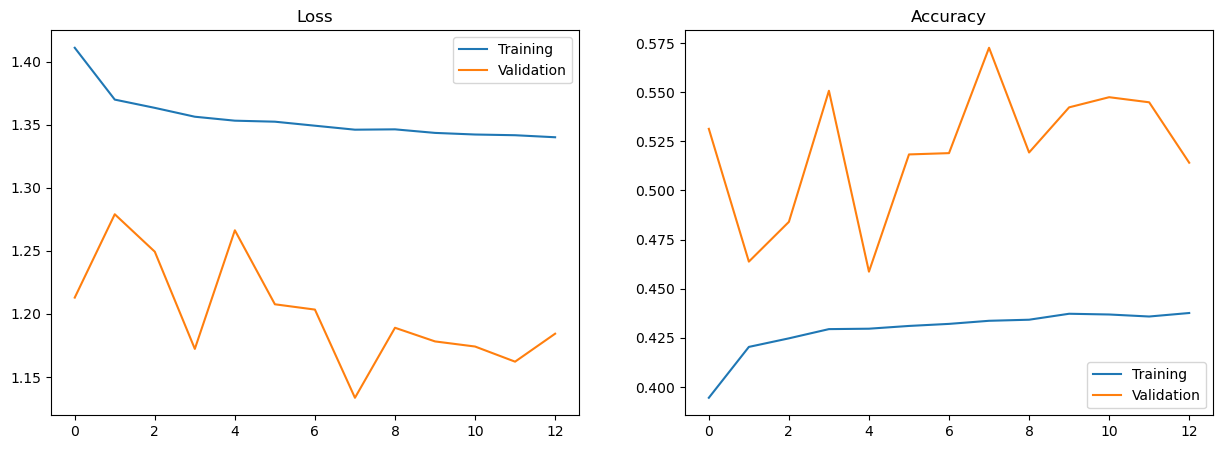

In [21]:
# plot training and validation metrics (loss and accuracy) over epochs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['sparse_categorical_accuracy'], label='Training')
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

(b) Obtain model evaluation metrics

In [22]:
# summary of the model's accuracy performance on both the training and test datasets
accuracy_tf = history.history['val_sparse_categorical_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['sparse_categorical_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_sparse_categorical_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_tf, training_time_tf/60))

Accuracy Training data: 43.8%
Accuracy Test data: 51.4%
Training time: 30534.0s (or 508.9 minutes)


In [26]:
# Predict the classes
y_pred = model_tf.predict(X_tf_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_tf_test, y_pred_classes, target_names=['Sadness', 'Joy', 'Love', 'Anger', 'Fear'])

print(report)

2378/2378 [==============================] - 691s 290ms/step
              precision    recall  f1-score   support

     Sadness       0.65      0.55      0.59     23630
         Joy       0.78      0.61      0.68     26942
        Love       0.34      0.42      0.38      5882
       Anger       0.48      0.52      0.50     10919
        Fear       0.38      0.70      0.49      8700

    accuracy                           0.57     76073
   macro avg       0.53      0.56      0.53     76073
weighted avg       0.62      0.57      0.58     76073



<b>Comments</b>

<b>Performance on: "Training" Data</b>
* The DistilBert model's performance on the training data is suboptimal, with an overall accuracy of 43.8%.

<b>Performance on: "Testing" Data</b>
* The model's performance on the testing data is slightly better than the training data, with an overall accuracy of 51.4%. However, the F1-scores for the classes show that the model is not performing well across all emotions, particularly for "Love" and "Fear".

<b>Evaluation Metrics of Interest</b>
* Accuracy: % of predictions that are correct. In this case, the accuracy is relatively low for both training and testing data.
* F1-Score: Composite measure that considers both “precision” and “recall”. The F1-scores for the classes "Love" and "Fear" are particularly low, indicating poor performance in these classes.

<b>Potential Reasons for Poor Performance</b>
* Model Complexity: DistilBert is a complex model which might be too sophisticated for this task, leading to longer training times and suboptimal results.
* Insufficient Training: The model might need more training time or more data to learn effectively.

<b>Key Insights & Steps Going Forward</b>
* Feature Engineering: Additional feature engineering, such as using GloVe-based word vectoriser, might help improve the model's performance by capturing more information from the text data. This aligns with existing literature that suggests that semantic understanding can be crucial for emotion classification tasks.
* Trying Simpler Models: Given the poor performance and long training times of the DistilBert model, it might be worth trying out simpler models like Naive Bayes, Logistic Regression, XGBoost, RandomForestClassifier, and Multinomial Classifier RNN with Glove word embeddings.
